In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from encoder import *

pd.options.display.max_columns = 200

from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import Lasso
from sklearn.tree import export_text, plot_tree
from pathlib import Path
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score
)
from sklearn.ensemble import HistGradientBoostingClassifier
from skrub import TableVectorizer
from sklearn.model_selection import cross_val_score, cross_validate

# 00.EDA

In [14]:
PATH = "/Users/thom/Desktop/DSB_year2/interpretability_stability_algorithm_fairness/dataproject2025.csv"
df = pd.read_csv(PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(30))

if "DP" in df.columns:
    print("DP distribution:")
    display(df["DP"].describe())
else:
    print("No DP column found — vérifie le nom exact dans le fichier de description.")

In [3]:
# Let's get rid of the Unnamed: 0 column
df = df.drop(columns=['Unnamed: 0'])

# 01.First Surrogates

In [4]:
df_clean = df.dropna(subset=["Predicted probabilities"])
df_clean = df_clean.dropna()

# On trie par ordre de date, parce qu'on ne veut pas prédire le passé avec l'avenir, un prêt accordé en 2015 ne l'était pas forcément en 2013
df_clean = df_clean.sort_values('issue_d')

print("Nb total:", len(df), " / Nb sans NaN:", len(df_clean))


y = df_clean["Predicted probabilities"]
X = df_clean.drop(columns=["Predicted probabilities", "Predictions", "target"])


X = pd.get_dummies(X, drop_first=True)


split_idx = int(len(df_clean) * 0.8) # on prend 80% de train et 20% de test


X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# Surrogate 1: shallow tree
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Tree R2 (fidelity to DP):", r2_score(y_test, pred_tree))

# Surrogate 2: linear regression
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
print("Linear R2 (fidelity to DP):", r2_score(y_test, pred_lin))

Nb total: 1086236  / Nb sans NaN: 1086236
Tree R2 (fidelity to DP): 0.714100022899538
Linear R2 (fidelity to DP): 0.9549919761049012


The R2 indicates that our surrogates approximate pretty well the default blackbox model, especially the linearregression, with an extremely good R2

Let's try to do an interpretation analysis thanks to our surrogates for first conclusions:

|--- int_rate <= 14.39
|   |--- int_rate <= 11.41
|   |   |--- grade_B <= 0.50
|   |   |   |--- value: [0.06]
|   |   |--- grade_B >  0.50
|   |   |   |--- value: [0.11]
|   |--- int_rate >  11.41
|   |   |--- loan duration <= 0.50
|   |   |   |--- value: [0.17]
|   |   |--- loan duration >  0.50
|   |   |   |--- value: [0.23]
|--- int_rate >  14.39
|   |--- loan duration <= 0.50
|   |   |--- int_rate <= 17.82
|   |   |   |--- value: [0.22]
|   |   |--- int_rate >  17.82
|   |   |   |--- value: [0.29]
|   |--- loan duration >  0.50
|   |   |--- int_rate <= 17.82
|   |   |   |--- value: [0.30]
|   |   |--- int_rate >  17.82
|   |   |   |--- value: [0.41]



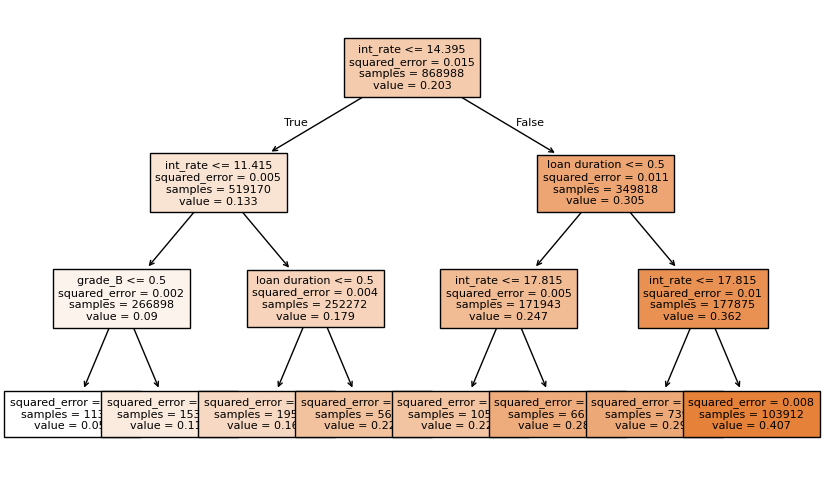

In [5]:
rules = export_text(tree, feature_names=list(X.columns))
print(rules)

plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=X.columns, filled=True, max_depth=3, fontsize=8)
plt.show()

In [6]:
coefs = pd.Series(lin.coef_, index=X.columns)
coefs_sorted = coefs.sort_values(key=np.abs, ascending=False)
print(coefs_sorted.head(10))

grade_G                   0.252337
grade_F                   0.217057
grade_E                   0.170471
grade_D                   0.118629
purpose_wedding          -0.091381
sub_grade_G5              0.085792
loan duration             0.084151
sub_grade_G4              0.082978
emp_title_associate      -0.078092
emp_title_truck driver    0.071754
dtype: float64


# 02.Our Blackbox Model

In [7]:
df_blackbox = df.dropna(subset=["Predicted probabilities"])
df_blackbox = df_blackbox.dropna()

# Comme au dessus, on trie par dates
df_blackbox = df_blackbox.sort_values('issue_d')

y = df_blackbox["target"]
# ce qui change par rapport à notre surrogate, puisqu'on ne prédit plus la prédiction de la target, mais la target directement
X = df_blackbox.drop(columns=["Predicted probabilities", "Predictions", "target"])

split_idx = int(len(df_blackbox) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

ord_transformer = FunctionTransformer(ordinal_encode, validate=False)


pipe = Pipeline([("ord", ord_transformer),("vec", TableVectorizer()), ("clf", HistGradientBoostingClassifier())])
pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, pred)*100:.2f}%")
print(f"AUC: {roc_auc_score(y_test, proba):.4f}")

Accuracy: 78.53%
AUC: 0.7164


# 03.Structural Stability

In [8]:
tscv = TimeSeriesSplit(n_splits=5)

# Le TimeSeriesSplit nous permet, ici aussi, d'assurer une forme de cohérence passé vs futur
auc_scores = cross_val_score(pipe, X, y, cv=tscv, scoring="roc_auc", n_jobs=-1)
print("AUC per fold:", np.round(auc_scores, 4))
print(f"Mean AUC: {auc_scores.mean():.4f} ± {auc_scores.std(ddof=1):.4f}")

# Accuracy + AUC avec cross_validate
scores = cross_validate(
    pipe, X, y, cv=tscv,
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    return_train_score=False,
    n_jobs=-1
)

print("\nAccuracy per fold:", np.round(scores["test_Accuracy"], 4))
print(f"Mean Accuracy: {scores['test_Accuracy'].mean():.4f} ± {scores['test_Accuracy'].std(ddof=1):.4f}")

AUC per fold: [0.713  0.7171 0.7203 0.7068 0.7184]
Mean AUC: 0.7151 ± 0.0054

Accuracy per fold: [0.7984 0.788  0.7942 0.7776 0.7864]
Mean Accuracy: 0.7889 ± 0.0080


# 04. Surrogate global interpretability

In [9]:
# Dans un premier temps, on prédit toutes les données, pour avoir toutes les prédictions du modèle et pouvoir évaluer ledit modèle avec le surrogate
pipe.fit(X,y)
proba_blackbox = pipe.predict_proba(X)[:, 1]
pred_blackbox = (proba_blackbox >= 0.5).astype(int)

In [10]:
df_blackbox_clean = df.dropna(subset=["Predicted probabilities"])
df_blackbox_clean = df_blackbox_clean.dropna()

# Comme au dessus, on trie par dates
df_blackbox = df_blackbox.sort_values('issue_d')

# On prend comme target pour notre surrogate les prédictions obtenues avec le blackbox
y = pred_blackbox
X = df_blackbox.drop(columns=["Predicted probabilities", "Predictions", "target"])

split_idx = int(len(df_blackbox) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Surrogate 1: shallow tree
tree = Pipeline([("ord", ord_transformer),("vec", TableVectorizer()),("reg",DecisionTreeRegressor(max_depth=3, random_state=42))])
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Tree R2 (fidelity to our blackbox):", r2_score(y_test, pred_tree))

# Surrogate 2: linear regression
from sklearn.linear_model import LinearRegression

lin = Pipeline([("ord", ord_transformer),("vec", TableVectorizer()),("reg",LinearRegression())])
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
print("Linear R2 (fidelity to our blackbox):", r2_score(y_test, pred_lin))

Tree R2 (fidelity to our blackbox): -0.0007827816943031252
Linear R2 (fidelity to our blackbox): -0.006012082099914551


The R2 indicate that our surrogates perform pretty bad when compared to our blackbox model

Let's try to do an interpretation analysis thanks to our surrogates for first conclusions:

In [11]:
tree = tree.named_steps["reg"]
rules = export_text(tree, feature_names=pipe[:-1].fit_transform(X_train).columns)
print(rules)

|--- issue_d <= 2014.50
|   |--- issue_d <= 2013.50
|   |   |--- bc_open_to_buy <= 167768.50
|   |   |   |--- value: [0.00]
|   |   |--- bc_open_to_buy >  167768.50
|   |   |   |--- value: [0.07]
|   |--- issue_d >  2013.50
|   |   |--- num_actv_bc_tl <= 24.50
|   |   |   |--- value: [0.01]
|   |   |--- num_actv_bc_tl >  24.50
|   |   |   |--- value: [0.50]
|--- issue_d >  2014.50
|   |--- issue_d <= 2016.50
|   |   |--- loan duration <= 0.50
|   |   |   |--- value: [0.04]
|   |   |--- loan duration >  0.50
|   |   |   |--- value: [0.04]
|   |--- issue_d >  2016.50
|   |   |--- int_rate <= 18.02
|   |   |   |--- value: [0.05]
|   |   |--- int_rate >  18.02
|   |   |   |--- value: [0.06]



IndexError: index 68 is out of bounds for axis 0 with size 35

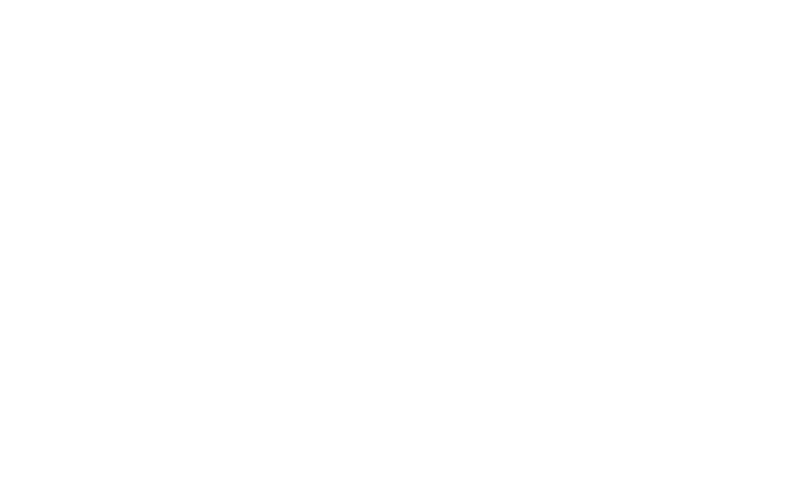

In [12]:
plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=pipe[:-1].fit_transform(X_train).columns, filled=True, max_depth=3, fontsize=8)
plt.show()

In [ ]:
lin = lin.named_steps["reg"]
X_transformed = pipe[:-1].fit_transform(X_train)  # pour transformer nos données avec l'encodage
coefs = pd.Series(lin.coef_, index=pd.DataFrame(X_transformed).columns)
coefs_sorted = coefs.sort_values(key=np.abs, ascending=False)
print(coefs_sorted.head(10))

# 05. PDP

In [ ]:
drop_cols = [c for c in ['target', 'Predicted probabilities', 'Predictions'] if c in df.columns]
X_pdp = df.drop(columns=drop_cols)

X_pdp = ordinal_encode(X_pdp)
num_feats = X_pdp.select_dtypes(include='number').columns.tolist()
features = num_feats[:3] if len(num_feats) > 0 else X_pdp.columns.tolist()[:3]
PartialDependenceDisplay.from_estimator(pipe, X_pdp, features=features, response_method='predict_proba', kind='average', subsample=100, random_state=42)
plt.tight_layout()
plt.show()

# 06. ICE

In [ ]:
# ICE
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
X = ordinal_encode(X)
if 'features' not in locals():
    _num = X.select_dtypes(include='number').columns.tolist()
    features = _num[:2] if _num else X.columns[:2]
PartialDependenceDisplay.from_estimator(pipe, X, features=features, response_method='predict_proba', kind='individual', subsample=100, target=1)
plt.tight_layout(); plt.show()
# LIME
from lime.lime_tabular import LimeTabularExplainer
vec, clf = pipe.named_steps['vec'], pipe.named_steps['clf']
Xt = vec.transform(X); Xt = Xt.toarray() if hasattr(Xt, 'toarray') else Xt
exp = LimeTabularExplainer(Xt, feature_names=vec.get_feature_names_out(), mode='classification')
print(exp.explain_instance(Xt[0], clf.predict_proba).as_list())

# 07. SHAP

In [ ]:
import shap

vec, clf = pipe.named_steps['vec'], pipe.named_steps['clf']
Xt = vec.transform(X); Xt = Xt.toarray() if hasattr(Xt, 'toarray') else Xt
feat_names = vec.get_feature_names_out()
idx = np.random.RandomState(42).choice(Xt.shape[0], size=min(300, Xt.shape[0]), replace=False)
explainer = shap.Explainer(clf, Xt[idx])
sv = explainer(Xt[idx])
shap.summary_plot(sv, Xt[idx], feature_names=feat_names, show=True)
vals = np.abs(sv.values).mean(0)
top = np.argsort(-vals)[:10]
print(list(zip(feat_names[top], vals[top])))

# 08. Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
X_test = ordinal_encode(X_test)
r = permutation_importance(pipe, X_test, y_test, scoring='roc_auc', n_repeats=20, random_state=42, n_jobs=-1)
idx = np.argsort(-r.importances_mean)
top_pi = [(X_test.columns[i], r.importances_mean[i], r.importances_std[i]) for i in idx[:10]]
print('Permutation importance (top 10):', top_pi)
if 'feat_names' in locals() and 'vals' in locals():
    top_shap_idx = np.argsort(-vals)[:10]
    shap_top = list(zip(feat_names[top_shap_idx], vals[top_shap_idx]))
    print('SHAP (top 10):', shap_top)

# 09. Permutation Importance

In [ ]:
from sklearn.metrics import roc_auc_score
prot_col = 'ethnicity'
s_test = df.loc[X_test.index, prot_col]
p = pipe.predict_proba(X_test)[:, 1]
y_true = y_test.values
y_pred = (p >= 0.5).astype(int)
ref = s_test.value_counts().idxmax()
rows = []
for g in s_test.unique():
    m = (s_test == g).values
    yt, yp, pp = y_true[m], y_pred[m], p[m]
    pos, neg = (yt == 1).sum(), (yt == 0).sum()
    tpr = (((yp == 1) & (yt == 1)).sum() / pos) if pos else np.nan
    fpr = (((yp == 1) & (yt == 0)).sum() / neg) if neg else np.nan
    sel = yp.mean() if len(yp) else np.nan
    aucg = roc_auc_score(yt, pp) if pos and neg else np.nan
    rows.append({'group': g, 'n': len(yt), 'selection_rate': sel, 'TPR': tpr, 'FPR': fpr, 'AUC': aucg})
grp = pd.DataFrame(rows).sort_values('n', ascending=False)
print(grp)
ref_row = grp[grp['group'] == ref].iloc[0]
spd = (grp['selection_rate'] - ref_row['selection_rate']).to_dict()
di  = (grp['selection_rate'] / ref_row['selection_rate']).replace([np.inf, -np.inf], np.nan).to_dict()
eo  = grp.apply(lambda r: max(abs(r['TPR'] - ref_row['TPR']), abs(r['FPR'] - ref_row['FPR'])), axis=1).to_dict()
print('reference_group:', ref)
print('statistical_parity_diff:', spd)
print('disparate_impact:', di)
print('equalized_odds_diff:', eo)

# 10. Fairness pdp

In [ ]:
prot_col = 'ethnicity'
if 'features' not in locals():
    _num = X.select_dtypes(include='number').columns.tolist()
    features = _num[:1] if _num else X.columns[:1]
s = df.loc[X_test.index, prot_col]
p = pipe.predict_proba(X_test)[:, 1]
yp = (p >= 0.5).astype(int)
ref = s.value_counts().idxmax()
def fpdp_spd(feature, n_bins=10, min_n=30):
    v = X_test[feature]
    bins = pd.qcut(v, q=min(n_bins, max(2, v.nunique())), duplicates='drop')
    t = pd.DataFrame({'bin': bins, 'pred': yp, 'group': s, 'val': v})
    rows = []
    for b, g in t.groupby('bin'):
        if len(g) < min_n:
            continue
        sel = g.groupby('group')['pred'].mean()
        spd = sel - sel.get(ref, np.nan)
        rows.append({'bin': str(b), 'center': g['val'].median(), 'spd_max_abs': spd.abs().max(), 'spd': spd.to_dict()})
    return pd.DataFrame(rows).sort_values('center')
res = fpdp_spd(features[0])
print(res[['bin','spd_max_abs']].head())
plt.figure()
plt.plot(res['center'], res['spd_max_abs'])
plt.xlabel(features[0]); plt.ylabel('SPD vs ref'); plt.title('FPDP (Statistical Parity Difference)')
plt.tight_layout();
plt.show()